# CM3070 Computer Science Final Project
# 03 Emotion Style Transfer

---

## **Table of Contents**  
1. [Introduction](#introduction)  
2. [Objectives](#objectives)  
3. [Setup and dependencies](#setup-and-dependencies)  
   - [Installing dependencies](#installing-dependencies)  
   - [Importing a Hifi-GAN vocoder](#importing-vocoder)  
4. [Baseline statistical prosody transfer](#baseline-statistical-prosody-transfer)
   - [Loading content and style features](#loading-content-and-style-features)
   - [Computing transferred prosody](#computing-transferred-prosody)
   - [Applying prosody to mel-spectrogram](#applying-prosody-to-mel)
   - [Vocoding and playback](#vocoding-and-playback)
5. [ML-based prosody transfer](#ML-based-prosody-transfer)
   - [Building neutral-emotion pairs](#building-neutral-emotion-pairs)
   - [Setting up the dataset and dataloader](#setting-up-the-dataset-and-dataloader)
   - [Defining the Mel2Mel model](#defining-the-mel2mel-model)
   - [Defining the training and evaluation loop](#defining-the-training-and-evaluation-model)
   - [Implementing hyperparameter tuning](#implementing-hyperparameter-tuning)
   - [Final model training](#final-model-training)
   - [Training all the emotion models](#training-all-the-emotion-models)
6. [Evaluating the ML-based prosody transfer models](#evaluating-the-ML-based-prosody-transfer-models)
   - [Loading models and preparing the evaluation setup](#loading-models-and-preparing-the-evaluation-setup)
   - [Transforming, visualising and playing back the results](#transforming-visualising-and-playing-back-the-results)
7. [Summary and next steps](#summary)

---

## 1. Introduction <a id="introduction"></a>

This notebook marks the third (and final) stage of a larger project on **Neural Style Transfer (NST) in Speech**, specifically focusing on transferring *emotions* from one speech signal to another. Building on previous notebooks where we prepared mel-spectrogram data and trained an emotion classifier, this stage explores whether the *style* — in this case, emotional expression such as happiness or anger — can be extracted and applied to a neutral speech sample.

We explore two approaches for the transfer of emotional prosody across neutral audios - a statistical approach and a machine-learning approach.

The effectiveness of the transfer is then evaluated both qualitatively and using the previously trained emotion classifier.

---

## 2. Objectives <a id="objectives"></a>

- Implement and test a **statistical style transfer baseline** (mean/variance alignment on mel-spectrograms).  
- Develop a **mel-to-mel learning-based model** to attempt stronger prosody transfer.  
- Reconstruct stylised spectrograms into audio using a pretrained **HiFi-GAN vocoder**.  
- Evaluate the emotional impact of the transformations using the trained CNN classifier and listening inspection.  
- Save and document the transformed outputs for further analysis.  

This stage acts as a proof of concept, highlighting both the feasibility and limitations of current approaches to **emotion transfer in speech**, and setting the stage for more advanced, feature-rich methods in future work.  

---

## 3. Setup and dependencies <a id="setup-and-dependencies"></a>
### Installing dependencies <a id="installing-dependencies"></a>
In this cell, we install the necessary Python packages for:

- a speech processing toolkit with pretrained models and pipelines (`speechbrain`)  
- the core deep learning framework used for building neural networks (`torch`)  
- audio processing utilities for PyTorch, including waveform I/O and transformations (`torchaudio`)  
- interactive computing features for Jupyter notebooks and Python shells (`IPython`)  

In [1]:
!pip install speechbrain torch torchaudio IPython --quiet

### Importing a Hifi-GAN vocoder <a id="importing-vocoder"></a>

We import and load a pretrained **HiFi-GAN vocoder** from SpeechBrain, which is used to convert mel-spectrograms back into natural-sounding speech waveforms. This vocoder enables high-quality audio synthesis and is essential for generating realistic speech signals from spectral features.

Please note that we suppress user and future warnings (triggered by deprecated backends in `torchaudio`) to keep the notebook output clean.

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from speechbrain.inference.vocoders import HIFIGAN
import torch

# detect device (GPU if available, else CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# load pretrained HiFi-GAN vocoder and move to device
hifi_gan = HIFIGAN.from_hparams(
    source="speechbrain/tts-hifigan-libritts-16kHz"
).to(device)

print("HiFi-GAN loaded successfully.")

Using device: cpu
HiFi-GAN loaded successfully.


---

## 4. Baseline statistical prosody transfer <a id="baseline-statistical-prosody-transfer"></a>
In this section, we attempt a simple statistical approach to transfer prosodic features (such as pitch, energy, MFCCs, and spectral characteristics) from one speech style to another. As an example, we demonstrate transferring prosody from a **neutral** utterance to an **angry** style.  
The approach relies on statistical normalization and blending of features rather than deep learning models, serving as a proof-of-concept baseline.

### Loading content and style features <a id="loading-content-and-style-features"></a>
We load pre-extracted features (mel-spectrogram, F0, energy, MFCCs, spectral features) for a neutral utterance (content) and an angry utterance (style), then print their shapes to verify.

In [3]:
import numpy as np

# load example content and style features
content_features = np.load("npys/neutral/03-01-01-01-01-01-01.npy", allow_pickle=True).item()
style_features = np.load("npys/angry/03-01-05-02-01-01-01.npy", allow_pickle=True).item()

# extract basic prosody
mel_content    = content_features["mel"]
mel_style      = style_features["mel"]
f0_content     = content_features["f0"]
f0_style       = style_features["f0"]
energy_content = content_features["energy"]
energy_style   = style_features["energy"]

# extract additional features
mfcc_content   = content_features.get("mfcc")
mfcc_style     = style_features.get("mfcc")
spectral_content = content_features.get("spectral")
spectral_style   = style_features.get("spectral")

# extract sample rate
sr = int(content_features["sr"])

# print shapes to verify
print("Mel shapes:", mel_content.shape, mel_style.shape)
print("F0 shapes:", f0_content.shape, f0_style.shape)
print("Energy shapes:", energy_content.shape, energy_style.shape)
if mfcc_content is not None:
    print("MFCC shapes:", mfcc_content.shape, mfcc_style.shape)
if spectral_content is not None:
    print("Spectral feature shapes:", spectral_content.shape, spectral_style.shape)

Mel shapes: (80, 256) (80, 256)
F0 shapes: (256,) (256,)
Energy shapes: (256,) (256,)
MFCC shapes: (39, 256) (39, 256)
Spectral feature shapes: (9, 256) (9, 256)


### Computing transferred prosody <a id="computing-transferred-prosody"></a>
We define a function that adjusts the prosodic features of the neutral utterance to match the statistical distribution (mean and variance) of the angry style. The result is a set of "transferred" features blending both content and style.

In [4]:
def compute_transferred_prosody(content_features, style_features, strength=1.0):
    """
    compute the target prosody values (f0, energy, MFCCs, spectral) by transferring
    style to content statistically. Returns a dictionary with arrays of the same shape as content.
    
    strength=0 -> keep content features
    strength=1 -> fully adopt style features
    """
    transferred = {}

    # --- f0 transfer ---
    f0_c, f0_s = content_features["f0"], style_features["f0"]
    f0_c_mean, f0_c_std = f0_c.mean(), f0_c.std()
    f0_s_mean, f0_s_std = f0_s.mean(), f0_s.std()
    f0_target = (f0_c - f0_c_mean) / (f0_c_std + 1e-6) * f0_s_std + f0_s_mean
    transferred["f0"] = (1 - strength) * f0_c + strength * f0_target

    # --- energy transfer ---
    energy_c, energy_s = content_features["energy"], style_features["energy"]
    energy_c_mean, energy_c_std = energy_c.mean(), energy_c.std()
    energy_s_mean, energy_s_std = energy_s.mean(), energy_s.std()
    energy_target = (energy_c - energy_c_mean) / (energy_c_std + 1e-6) * energy_s_std + energy_s_mean
    transferred["energy"] = (1 - strength) * energy_c + strength * energy_target

    # --- MFCC transfer (frame-wise linear scaling) ---
    if "mfcc" in content_features and "mfcc" in style_features:
        mfcc_c, mfcc_s = content_features["mfcc"], style_features["mfcc"]
        mfcc_target = (mfcc_c - mfcc_c.mean(axis=1, keepdims=True)) / \
                      (mfcc_c.std(axis=1, keepdims=True) + 1e-6) * \
                      mfcc_s.std(axis=1, keepdims=True) + mfcc_s.mean(axis=1, keepdims=True)
        transferred["mfcc"] = (1 - strength) * mfcc_c + strength * mfcc_target

    # --- spectral features transfer (frame-wise linear scaling) ---
    if "spectral" in content_features and "spectral" in style_features:
        spec_c, spec_s = content_features["spectral"], style_features["spectral"]
        spec_target = (spec_c - spec_c.mean(axis=1, keepdims=True)) / \
                      (spec_c.std(axis=1, keepdims=True) + 1e-6) * \
                      spec_s.std(axis=1, keepdims=True) + spec_s.mean(axis=1, keepdims=True)
        transferred["spectral"] = (1 - strength) * spec_c + strength * spec_target

    return transferred

# --- example usage ---
transferred_features = compute_transferred_prosody(content_features, style_features, strength=0.7)

print("Transferred f0 shape:", transferred_features["f0"].shape)
print("Transferred energy shape:", transferred_features["energy"].shape)
if "mfcc" in transferred_features:
    print("Transferred MFCC shape:", transferred_features["mfcc"].shape)
if "spectral" in transferred_features:
    print("Transferred spectral shape:", transferred_features["spectral"].shape)

Transferred f0 shape: (256,)
Transferred energy shape: (256,)
Transferred MFCC shape: (39, 256)
Transferred spectral shape: (9, 256)


### Applying prosody to mel-spectrogram <a id="applying-prosody-to-mel"></a>
We apply the transferred prosodic features (F0, energy, MFCCs, spectral) back onto the original mel-spectrogram of the neutral utterance, producing a stylized mel-spectrogram that reflects the target style.

In [5]:
def apply_prosody_to_mel(mel, features, 
                              f0_strength=0.5, 
                              energy_strength=0.5, 
                              mfcc_strength=0.5, 
                              spec_strength=0.5):
    """
    safely apply all prosody and spectral features to a mel spectrogram.
    
    args:
        mel: np.ndarray [n_mels, T]
        features: dict containing 'f0', 'energy', 'mfcc', 'spectral'
        *_strength: blending coefficients for each feature
    returns:
        mel_out: np.ndarray [n_mels, T]
    """
    mel_out = np.copy(mel)
    T = mel.shape[1]

    # --- energy ---
    energy = features["energy"]
    energy_norm = energy / (np.max(energy) + 1e-6)
    mel_out *= 1 + energy_strength * (energy_norm - 0.5)  # mild scaling

    # --- F0 (smooth ratio) ---
    f0 = features["f0"]
    f0_ratio = f0 / (np.mean(f0) + 1e-6)
    f0_ratio = np.clip(f0_ratio, 0.85, 1.15)
    mel_out = mel_out * (1 + f0_strength * (f0_ratio - 1.0))  # smooth gain modulation

    # --- MFCC features ---
    mfcc = features.get("mfcc")
    if mfcc is not None:
        mfcc_mean = np.mean(mfcc, axis=0)
        mfcc_norm = (mfcc_mean - np.mean(mfcc_mean)) / (np.std(mfcc_mean)+1e-6)
        mel_out += mfcc_strength * mfcc_norm[:T]

    # --- spectral features ---
    spec = features.get("spectral")
    if spec is not None:
        spec_mean = np.mean(spec, axis=0)
        spec_norm = (spec_mean - np.mean(spec_mean)) / (np.std(spec_mean)+1e-6)
        mel_out += spec_strength * spec_norm[:T]

    # --- gentle clipping ---
    mel_out = np.clip(mel_out, -8.0, 8.0)

    return mel_out

mel_stylized = apply_prosody_to_mel(mel_content, transferred_features)

### Vocoding and playback <a id="vocoding-and-playback"></a>
We use the HiFi-GAN vocoder from SpeechBrain to decode the original neutral, the original angry, and the stylized mel-spectrograms into audio waveforms, allowing us to listen to the effect of the prosody transfer.

In [6]:
from IPython.display import Audio

# convert to torch and decode
mel_tensor = torch.tensor(mel_stylized).unsqueeze(0).to(device)
waveform_stylized = hifi_gan.decode_batch(mel_tensor).squeeze(0).cpu().numpy()

# play all audio
print("Content audio (neutral):")
display(Audio(hifi_gan.decode_batch(torch.tensor(mel_content).unsqueeze(0)).squeeze(0).cpu(), rate=sr))

print("Style audio (angry):")
display(Audio(hifi_gan.decode_batch(torch.tensor(mel_style).unsqueeze(0)).squeeze(0).cpu(), rate=sr))

print("Stylized output (neutral -> angry):")
display(Audio(waveform_stylized, rate=sr))

Content audio (neutral):


Style audio (angry):


Stylized output (neutral -> angry):


---

## 5. ML-based prosody transfer <a id=""></a> <a id="ML-based-prosody-transfer"></a>
While the statistical method provided a simple baseline, we now adopt a more data-driven strategy to learn how prosody transfers from neutral speech to various emotions. In this approach, we use paired neutral–emotion utterances (e.g., neutral → angry) as training data. A sequence-to-sequence model is trained to predict the difference (delta) between neutral and emotional mel-spectrograms, allowing it to capture prosodic transformations in a more flexible and expressive way. The architecture relies on convolutional and bidirectional LSTM layers, followed by a decoder, making it capable of learning temporal dynamics of speech style transfer.

### Building neutral-emotion pairs <a id="building-neutral-emotion-pairs"></a>
This cell constructs pairs of neutral and target-emotion samples from both the RAVDESS and CREMA-D datasets. These pairs form the basis of training data, ensuring each model learns how neutral speech maps into a given emotional style.

In [7]:
import os
from glob import glob

# --- emotion maps ---
ravdess_emotions = {
    "happy": "03",
    "sad": "04",
    "angry": "05",
    "fearful": "06",
    "disgust": "07"
}

cremad_emotions = {
    "happy": "HAP",
    "angry": "ANG",
    "fearful": "FEA",
    "disgust": "DIS",
    "sad": "SAD"
}

def build_ravdess_pairs_for_emotion(npy_root="npys", target_emotion="happy"):
    neutral_dir = os.path.join(npy_root, "neutral")
    emo_code = ravdess_emotions[target_emotion]
    pairs = []

    for neutral_path in glob(os.path.join(neutral_dir, "03-01-01-01-*.npy")):
        fname = os.path.basename(neutral_path).replace(".npy", "")
        parts = fname.split("-")
        if len(parts) < 7:
            continue
        statement, repetition, actor = parts[4], parts[5], parts[6]
        target_fname = f"03-01-{emo_code}-02-{statement}-{repetition}-{actor}.npy"
        target_path = os.path.join(npy_root, target_emotion, target_fname)
        if os.path.exists(target_path):
            pairs.append((neutral_path, target_path))
    return pairs

def build_cremad_pairs_for_emotion(npy_root="npys", target_emotion="happy"):
    neutral_dir = os.path.join(npy_root, "neutral")
    emo_code = cremad_emotions[target_emotion]
    pairs = []

    for neutral_path in glob(os.path.join(neutral_dir, "*.npy")):
        fname = os.path.basename(neutral_path).replace(".npy", "")
        parts = fname.split("_")
        if len(parts) != 4:
            continue
        actor, sentence, emo, intensity = parts
        if emo != "NEU":
            continue
        target_fname = f"{actor}_{sentence}_{emo_code}_HI.npy"
        target_path = os.path.join(npy_root, target_emotion, target_fname)
        if os.path.exists(target_path):
            pairs.append((neutral_path, target_path))
    return pairs

# --- build combined lists for each emotion ---
emotion_pairs = {}
for emotion in ["happy", "sad", "angry", "fearful", "disgust"]:
    ravdess = build_ravdess_pairs_for_emotion(target_emotion=emotion)
    cremad = build_cremad_pairs_for_emotion(target_emotion=emotion)
    emotion_pairs[emotion] = ravdess + cremad
    print(f"{emotion.capitalize()} pairs: {len(emotion_pairs[emotion])}")

Happy pairs: 187
Sad pairs: 187
Angry pairs: 187
Fearful pairs: 187
Disgust pairs: 187


### Setting up the dataset and dataloader <a id="setting-up-the-dataset-and-dataloader"></a>
A custom MelToMelDataset is defined, which loads paired neutral and emotional mel-spectrograms. The dataset outputs input (neutral mel) and target (delta mel) tensors, ready to be fed into the model. A helper function generates DataLoaders for batching and shuffling.

In [8]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np

class MelToMelDataset(Dataset):
    def __init__(self, pairs):
        """
        pairs: list of (neutral_path, target_path)
        """
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        neutral_path, target_path = self.pairs[idx]

        # load precomputed mels
        mel_neutral = np.load(neutral_path, allow_pickle=True).item()["mel"]
        mel_target  = np.load(target_path, allow_pickle=True).item()["mel"]

        # convert to torch tensors
        mel_in  = torch.tensor(mel_neutral, dtype=torch.float32)
        mel_out = torch.tensor(mel_target-mel_neutral, dtype=torch.float32) # delta mel

        return mel_in, mel_out

def get_dataloader_for_emotion(pairs, batch_size=8, shuffle=True):
    dataset = MelToMelDataset(pairs)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
    return dataset, loader

### Defining the Mel2Mel model <a id="defining-the-mel2mel-model"></a>

Here, the Mel2Mel model is implemented. It consists of:
- a convolutional encoder to extract local spectral patterns,
- a bidirectional LSTM to capture temporal dependencies in prosody, and
- a convolutional decoder to reconstruct the target mel differences.

This design allows the network to learn how prosodic features evolve over time.

In [9]:
import torch
import torch.nn as nn

class Mel2Mel(nn.Module):
    def __init__(self, n_mels=80, hidden_dim=256, num_lstm_layers=2, kernel_size=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(n_mels, hidden_dim, kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_lstm_layers, 
                            batch_first=True, bidirectional=True)
        self.decoder = nn.Sequential(
            nn.Conv1d(hidden_dim*2, hidden_dim, kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, n_mels, kernel_size=kernel_size, padding=kernel_size//2)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        z = z.permute(0, 2, 1)
        z, _ = self.lstm(z)
        z = z.permute(0, 2, 1)
        out = self.decoder(z)
        return out

### Defining the training and evaluation loop <a id="defining-the-training-and-evaluation-model"></a>

This function trains the Mel2Mel model using MSE loss between predicted and target deltas. It includes forward/backward propagation, weight updates with Adam, and logs training loss. After training, validation loss is computed to measure generalization.

In [10]:
import torch.optim as optim

def train_and_evaluate(model, train_loader, val_loader, num_epochs=3, lr=1e-3, device="cuda"):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # training loop
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for mel_in, mel_out in train_loader:
            mel_in, mel_out = mel_in.to(device), mel_out.to(device)
            pred = model(mel_in)
            loss = criterion(pred, mel_out)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * mel_in.size(0)
        avg_train_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch}/{num_epochs} - Training Loss: {avg_train_loss:.6f}")

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for mel_in, mel_out in val_loader:
            mel_in, mel_out = mel_in.to(device), mel_out.to(device)
            pred = model(mel_in)
            loss = criterion(pred, mel_out)
            val_loss += loss.item() * mel_in.size(0)
    val_loss /= len(val_loader.dataset)
    
    return val_loss

### Implementing hyperparameter tuning <a id="implementing-hyperparameter-tuning"></a>
A simple search routine is implemented to tune key hyperparameters such as learning rate, hidden dimension, LSTM depth, batch size, and kernel size. The best configuration is chosen based on validation loss across multiple trials.

In [11]:
import numpy as np
from torch.utils.data import random_split

def hyperparameter_search(dataset, n_mels, device="cuda", num_trials=5, num_epochs=3):
    search_space = {
        "learning_rate": [1e-4, 3e-4, 1e-3],
        "hidden_dim": [128, 256, 512],
        "num_lstm_layers": [1, 2, 3],
        "batch_size": [4, 8, 16],
        "kernel_size": [3, 5]
    }

    val_frac = 0.1
    val_size = int(len(dataset) * val_frac)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    best_val_loss = float('inf')
    best_params = None

    for trial in range(num_trials):
        lr = float(np.random.choice(search_space["learning_rate"]))
        hidden_dim = int(np.random.choice(search_space["hidden_dim"]))
        num_lstm = int(np.random.choice(search_space["num_lstm_layers"]))
        batch_size = int(np.random.choice(search_space["batch_size"]))
        kernel_size = int(np.random.choice(search_space["kernel_size"]))

        print(f"\nTrial {trial+1}: lr={lr}, hidden={hidden_dim}, lstm={num_lstm}, batch={batch_size}, kernel={kernel_size}")

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = Mel2Mel(n_mels=n_mels, hidden_dim=hidden_dim, 
                        num_lstm_layers=num_lstm, kernel_size=kernel_size).to(device)

        val_loss = train_and_evaluate(model, train_loader, val_loader, num_epochs=num_epochs, lr=lr, device=device)
        print(f"Validation loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = {
                "lr": lr, "hidden_dim": hidden_dim, "num_lstm_layers": num_lstm,
                "batch_size": batch_size, "kernel_size": kernel_size
            }

    print("\nBest hyperparameters found:")
    print(best_params)
    print("Best validation loss:", best_val_loss)
    return best_params

### Final model training <a id="final-model-training"></a>
All the above cells are put together into a single function to carry out the whole process of building and training the final model. Once trained, it is also saved for future inference, ensuring reproducibility.

In [12]:
def train_final_model(dataset, n_mels, best_params, device="cuda", num_epochs=20, save_path="saved_models/mel2mel_final.pt"):
    # ensure the folder exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    loader = DataLoader(dataset, batch_size=best_params['batch_size'], shuffle=True)
    
    model = Mel2Mel(
        n_mels=n_mels,
        hidden_dim=best_params['hidden_dim'],
        num_lstm_layers=best_params['num_lstm_layers'],
        kernel_size=best_params['kernel_size']
    ).to(device)
    
    final_loss = train_and_evaluate(model, loader, loader, num_epochs=num_epochs, lr=best_params['lr'], device=device)
    print("Final training loss:", final_loss)
    
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")
    
    return model

### Training all the emotion models <a id="training-all-the-emotion-models"></a>
The entire workflow is executed for each target emotion (happy, sad, angry, fearful, disgust). For every emotion, neutral–emotion pairs are built, hyperparameter search is conducted, and a final Mel2Mel model is trained and saved. This produces one specialized prosody transfer model per emotion.

In [13]:
import pandas as pd

emotions = ["happy", "sad", "angry", "fearful", "disgust"]
results = []

for emo in emotions:
    print(f"\n=== Processing emotion: {emo} ===")
    dataset, loader = get_dataloader_for_emotion(emotion_pairs[emo])
    n_mels = dataset[0][0].shape[0]

    # hyperparameter search
    best_params = hyperparameter_search(dataset, n_mels, device=device, num_trials=3, num_epochs=3)

    # add emotion label and save in results list
    row = {"emotion": emo}
    row.update(best_params)
    results.append(row)

    # final training
    save_path = f"saved_models/mel2mel_{emo}_final.pt"
    final_model = train_final_model(dataset, n_mels, best_params, device=device, num_epochs=20, save_path=save_path)

# save all best_params to CSV
df = pd.DataFrame(results)
df.to_csv("saved_models/best_params.csv", index=False)
print("\nBest hyperparameters saved to saved_models/best_params.csv")


=== Processing emotion: happy ===

Trial 1: lr=0.0001, hidden=128, lstm=3, batch=8, kernel=5
Epoch 1/3 - Training Loss: 19.472613
Epoch 2/3 - Training Loss: 18.400624
Epoch 3/3 - Training Loss: 17.651445
Validation loss: 18.731643

Trial 2: lr=0.0003, hidden=256, lstm=3, batch=16, kernel=5
Epoch 1/3 - Training Loss: 19.173923
Epoch 2/3 - Training Loss: 17.601056
Epoch 3/3 - Training Loss: 17.381128
Validation loss: 18.965870

Trial 3: lr=0.0001, hidden=128, lstm=2, batch=4, kernel=5
Epoch 1/3 - Training Loss: 19.097170
Epoch 2/3 - Training Loss: 17.698821
Epoch 3/3 - Training Loss: 17.612398
Validation loss: 18.443653

Best hyperparameters found:
{'lr': 0.0001, 'hidden_dim': 128, 'num_lstm_layers': 2, 'batch_size': 4, 'kernel_size': 5}
Best validation loss: 18.443652682834202
Epoch 1/20 - Training Loss: 18.954866
Epoch 2/20 - Training Loss: 17.521191
Epoch 3/20 - Training Loss: 17.658838
Epoch 4/20 - Training Loss: 16.880026
Epoch 5/20 - Training Loss: 16.066445
Epoch 6/20 - Training 

---

## 6. Evaluating the ML-based prosody transfer models <a id="evaluating-the-ML-based-prosody-transfer-models"></a>
Having trained one Mel2Mel model per emotion, we now evaluate their ability to transform a neutral utterance into different emotional styles. The evaluation process involves generating transformed spectrograms, classifying them with a pretrained CNN emotion recognizer, and finally listening to the reconstructed audio using HiFi-GAN. This allows us to assess both quantitative recognition accuracy and qualitative perceptual quality of the style transfer.

### Loading models and preparing the evaluation setup <a id="loading-models-and-preparing-the-evaluation-setup"></a>
This cell loads the trained Mel2Mel models for each emotion along with a pretrained CNN classifier for emotion recognition (from the previous notebook). It also prepares the neutral mel-spectrogram as the input baseline and stores best hyperparameters per emotion to rebuild models consistently.

In [14]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# --- settings ---
neutral_path = "npys/neutral/03-01-01-01-01-01-01.npy"
emotions = ["happy", "sad", "angry", "fearful", "disgust"]

# --- load best hyperparameters from CSV ---
df = pd.read_csv("saved_models/best_params.csv")

# convert dataframe rows into dictionary of dicts
best_params_dict = {
    row["emotion"]: {
        "lr": row["lr"],
        "hidden_dim": int(row["hidden_dim"]),
        "num_lstm_layers": int(row["num_lstm_layers"]),
        "batch_size": int(row["batch_size"]),
        "kernel_size": int(row["kernel_size"])
    }
    for _, row in df.iterrows()
}

# --- load neutral mel ---
neutral_mel = np.load(neutral_path, allow_pickle=True).item()["mel"]
neutral_mel_tensor = torch.tensor(neutral_mel, dtype=torch.float32).unsqueeze(0).to(device)  # [1, n_mels, T]

# --- load CNN classifier ---
cnn_model = load_model("emotion_cnn_best.keras")

# --- load emotion models ---
emotion_models = {}
for emo in emotions:
    params = best_params_dict[emo]
    model = Mel2Mel(
        n_mels=neutral_mel.shape[0],
        hidden_dim=params['hidden_dim'],
        num_lstm_layers=params['num_lstm_layers'],
        kernel_size=params['kernel_size']
    ).to(device)
    model.load_state_dict(torch.load(f"saved_models/mel2mel_{emo}_final.pt", map_location=device))
    model.eval()
    emotion_models[emo] = model

# --- emotion mapping ---
emotion_labels = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust']

### Transforming, visualising and playing back the results <a id="transforming-visualising-and-playing-back-the-results"></a>
Each Mel2Mel model transforms the neutral mel-spectrogram into its target emotion by predicting a delta and applying it back. The resulting spectrogram is:
- visualized as a heatmap to observe structural changes in frequency and intensity,
- classified by the CNN to verify whether the intended emotion was recognized, and finally
- synthesized into audio via HiFi-GAN for listening tests, enabling subjective evaluation of prosody transfer.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


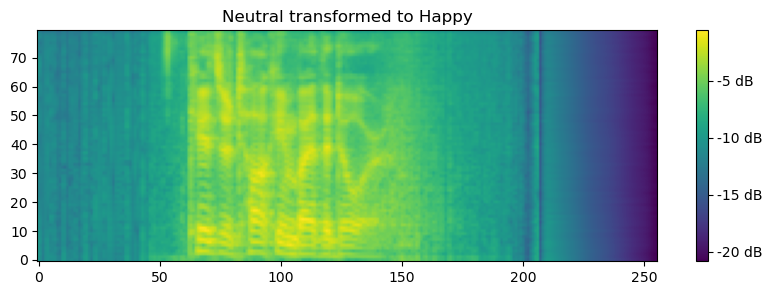

Playing neutral -> happy audio (CNN predicted: neutral)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


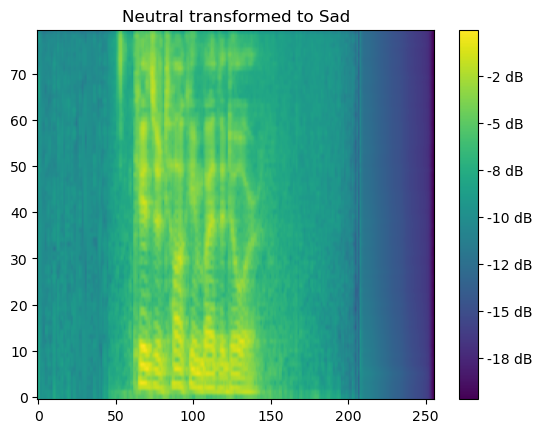

Playing neutral -> sad audio (CNN predicted: neutral)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


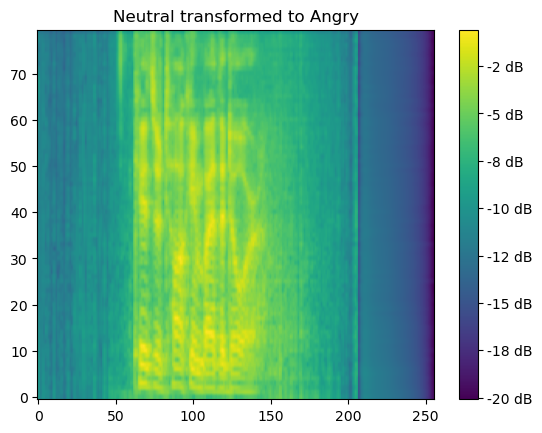

Playing neutral -> angry audio (CNN predicted: neutral)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


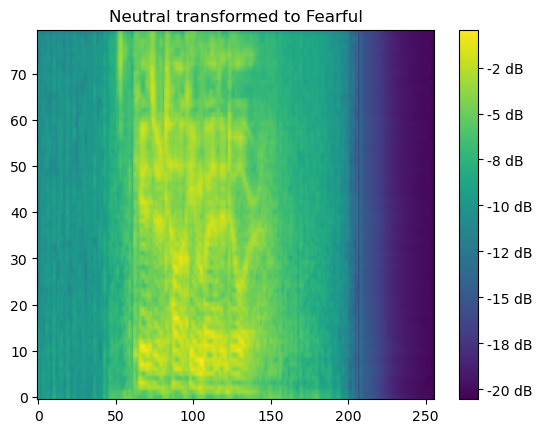

Playing neutral -> fearful audio (CNN predicted: neutral)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


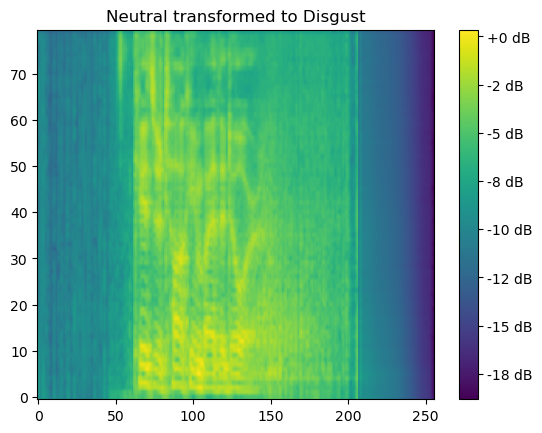

Playing neutral -> disgust audio (CNN predicted: neutral)


In [15]:
# --- transform, visualize, and play ---
plt.figure(figsize=(10, 3))

for i, emo in enumerate(emotions):
    with torch.no_grad():
        delta_pred = emotion_models[emo](neutral_mel_tensor)
        mel_transformed = neutral_mel_tensor + delta_pred  # revert delta to get full mel
        mel_np = mel_transformed.cpu().numpy().squeeze()

    # predict with CNN
    cnn_input = mel_np[np.newaxis, :, :, np.newaxis]
    pred = cnn_model.predict(cnn_input)
    pred_label = pred.argmax(axis=-1)[0]

    # --- plot spectrogram ---
    plt.clf()
    plt.imshow(mel_np, aspect='auto', origin='lower')
    plt.title(f"Neutral transformed to {emo.capitalize()}")
    plt.colorbar(format="%+2.f dB")
    plt.show()

     # --- play audio ---
    print(f"Playing neutral -> {emo} audio (CNN predicted: {emotion_labels[pred_label]})")
    mel_tensor = torch.tensor(mel_np, dtype=torch.float32).unsqueeze(0).to(device)
    waveform = hifi_gan.decode_batch(mel_tensor).squeeze().cpu().numpy()
    display(Audio(waveform, rate=sr))

---

## 7. Summary and next steps <a id="summary"></a>

### **Summary**  
Across both the **statistical baseline** and the **ML-based Mel2Mel models**, the transformed outputs were clearly audible and reconstructable. However, the degree of prosody transfer was limited. Despite applying different feature manipulations and training dedicated models for each emotion, the **CNN classifier consistently predicted the outputs as neutral**, suggesting that the prosodic modifications were not strong enough to shift the perceived emotional category.  

This highlights a key limitation: while the transformations altered spectrogram structures, they did not meaningfully affect the higher-level prosodic cues (intonation, rhythm, stress patterns) that human listeners and classifiers rely on to detect emotion. In other words, the models produced measurable changes, but these changes lacked the perceptual or semantic weight to cross category boundaries.  

From a broader perspective, this outcome is valuable. It confirms that simple statistical adjustments and direct mel-to-mel mapping are insufficient for convincing prosody transfer, and that richer representations of speech (e.g., pitch contours, duration models, or phoneme-level alignment) may be necessary. It also illustrates the challenge of emotion transfer in speech — subtle prosodic shifts carry meaning, but replicating them computationally requires nuanced modeling.  



### **Next Steps**  
Future work can focus on several directions to improve the quality and impact of prosody transfer:  

1. **Richer Feature Representations**  
   - Incorporate explicit **pitch contour modeling** (e.g., continuous F0 trajectories) and **temporal dynamics** rather than relying solely on mel deltas.  
   - Leverage embeddings from **self-supervised speech models** (like HuBERT or Wav2Vec2) that capture semantic and prosodic features beyond raw spectrograms.  


2. **Improved Model Architectures**  
   - Replace direct mel-to-mel mapping with **sequence-to-sequence or transformer-based models** capable of modeling long-range dependencies in speech.  
   - Explore **variational autoencoders (VAEs)** or **generative adversarial networks (GANs)** for better style disentanglement and expressive synthesis.  


3. **Emotion Conditioning**  
   - Train unified models that take both neutral audio and a **target emotion embedding** as input, allowing for controllable transfer across multiple emotions in a single system.  


4. **Evaluation Enhancements**  
   - Supplement classifier-based evaluation with **listening tests** to measure perceptual naturalness and emotional clarity.  
   - Use objective prosody metrics (F0 variance, speech rate, energy distribution) to quantify style differences.  


5. **Dataset Expansion**  
   - Augment training with more diverse and **multi-speaker emotional datasets** to reduce overfitting and capture broader prosodic variability.  

Taken together, these steps could enable more expressive prosody transfer, bridging the gap between measurable acoustic modifications and perceptually meaningful emotional shifts.